In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.executable

'D:\\Anaconda3\\python.exe'

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# let's drop the Time column, since it's only shows sec-s elapsed b/n the given
# and the first transaction in the dataset.
df = df.drop(['Time'], axis=1)
df.shape # number of transactions = # of rows

(284807, 30)

# Exploratory analysis

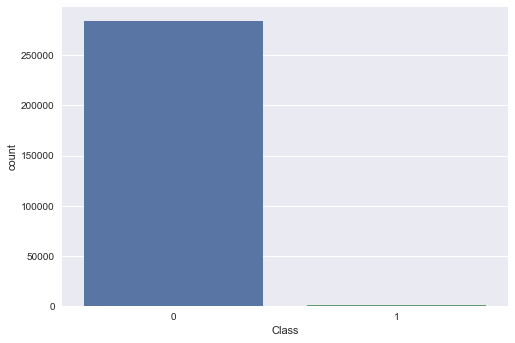

In [4]:
import seaborn as sns
sns.set(color_codes=True)
sns.countplot(df['Class'])

We can clearly how skewed the distribution is towards legitimate transactions (frauds account for only 0.172% of transactions). That's why using the number of correctly classified transactions will not be representative of the performance of a classification model. Our model may just use the dominant class for all predictions and still be very accurate. 

# Data preprocessing

In [5]:
from sklearn.model_selection import train_test_split

X = df.ix[:, df.columns != 'Class']
y = df['Class']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

Since anononimized features V1-V28 are the result of a PCA transformation we don't need to normalize them, we only need to do so to column "Amount".

In [6]:
from sklearn.preprocessing import StandardScaler
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['Amount'].head()

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
Name: Amount, dtype: float64

# Accuracy vs Kappa

In [7]:
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

In [8]:
logReg = LogisticRegression(C = 0.01)
logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)

logReg.score(X_test, y_test)


0.99912222183209864

In [9]:
cohen_kappa_score(y_test, y_pred)
# Classification accuracy normalized by the imbalance of classes

0.64244366111779128

We see how deceiving accuracy can be when the class distribution is extremely skewed.

# Oversampling with Synthetic Minory Over-sampling Technique (SMOTE)

In [15]:
from imblearn.over_sampling import SMOTE

oversampler=SMOTE(random_state=1)
os_X, os_Y = oversampler.fit_sample(X_train, y_train)

In [16]:
#let's use Log Reg again but this time on balanced data 
logReg.fit(os_X, os_Y)
y_pred = logReg.predict(X_test)

In [17]:
from sklearn.metrics import roc_curve, auc
#y_pred=logReg.predict(X_test)
false_positive_rate, true_positive_rate, thresholds \
= roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.92330701023114814

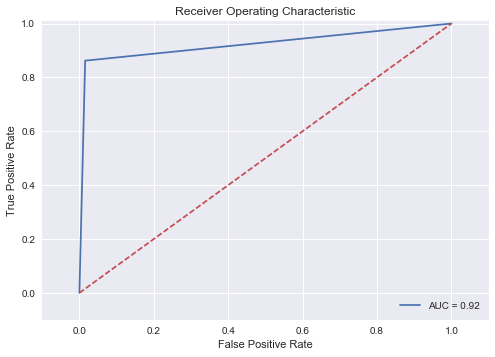

In [18]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [19]:
# https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/